In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 

import torch
torch.manual_seed(0)

import numpy as np 
np.random.seed(0)

## Task 2: Create Models

In [3]:
from models import *

In [4]:
# Since we're only using MNIST and Fashion MNIST, we can hardcode the following parameters.
n_channels = 1 
img_dim = 28 
n_classes = 10 

Our first model, PaperCNN, is the CNN model used in the paper. 

In [5]:
model = PaperCNN(n_channels, n_classes)
print(model)

PaperCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)


Our second model, Alexish, is a CNN loosely based on AlexNet.

In [6]:
model = Alexish(n_channels, n_classes)
print(model)

Alexish(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear): Sequential(
    (0): Linear(in_features=6272, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Task 3: Training Models 

In [7]:
from train import train_main

We have two models (PaperCNN and Alexish) and two datasets (MNIST and FashionMNIST). Let's begin by training both models on both datasets. The resulting model checkpoints are stored in ```{outdir}/model_ckpts/{model_name}_{dataset}.pt```

In [8]:
outdir='./'

for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:
        train_main(outdir=outdir, dataset_name=dataset_name, model_name=model_name, batch_size=32, epochs=10)

**************************************************
Training PaperCNN on mnist
**************************************************
Epoch 1/10 | Loss: 0.12771867215633392
Saved best model, current test acc is 98.78%
Epoch 2/10 | Loss: 0.03996114805340767
Epoch 3/10 | Loss: 0.028353029862046242
Saved best model, current test acc is 99.19%
Epoch 4/10 | Loss: 0.020151417702436447
Saved best model, current test acc is 99.24%
Epoch 5/10 | Loss: 0.016823850572109222
Epoch 6/10 | Loss: 0.012689538300037384
Epoch 7/10 | Loss: 0.010353542864322662
Epoch 8/10 | Loss: 0.009003481827676296
Epoch 9/10 | Loss: 0.008821168914437294
Epoch 10/10 | Loss: 0.005212883464992046
**************************************************
Training PaperCNN on fashion_mnist
**************************************************
Epoch 1/10 | Loss: 0.4543333947658539
Saved best model, current test acc is 85.82%
Epoch 2/10 | Loss: 0.29600802063941956
Saved best model, current test acc is 88.46%
Epoch 3/10 | Loss: 0.251309186220

## Task 4: Classification Images (aka Average Noise Maps)

In [9]:
from classification_image import *

We begin by calculating the average noise maps for each model. For each model, there is an average noise map for each class of the dataset. We also visualize those average noise maps, determine what the model classifies them as, and use the noise maps as a classifier. 

#### Notes: 

- There may be some noise maps that are all zeros (completely purple). This occurs when none of the noise images from the trials are classified as that particular class. We then assign noise maps of zero to that class to avoid classification issues down the line with nans. Running more trials can solve this issue but requires a longer runtime. 
- The cell values shown in the confusion matrices are class accuracies (i.e. normalized across rows)

********************************************************************************
Calculating classification images for PaperCNN trained on mnist
********************************************************************************


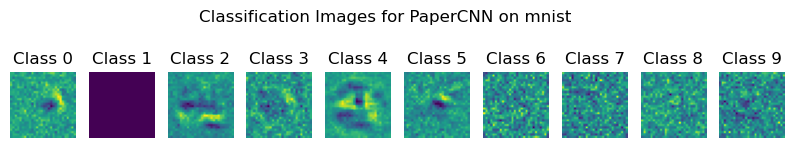

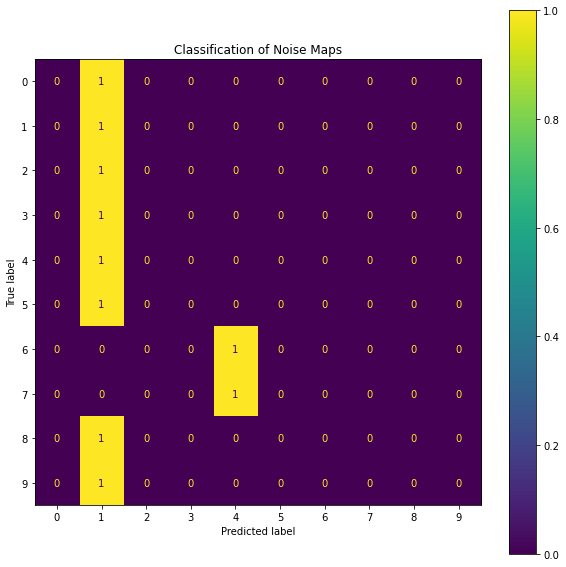



Using average noise maps as classifiers


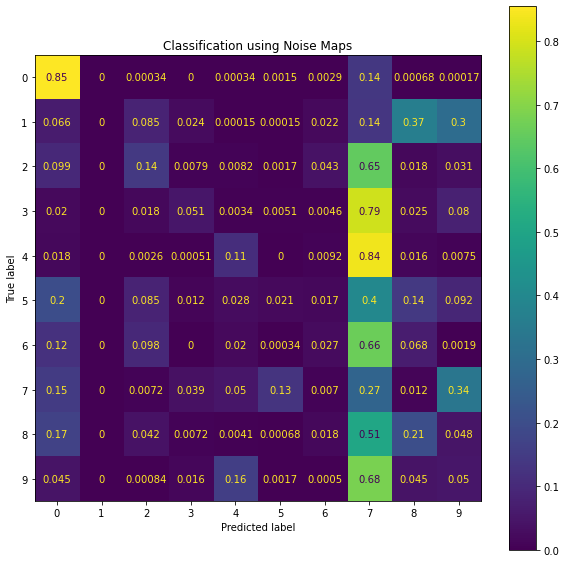

********************************************************************************
Calculating classification images for PaperCNN trained on fashion_mnist
********************************************************************************


In [ ]:
outdir = './'

# Path where model checkpoints are stored 
ckpt_path = os.path.join(outdir, 'model_ckpts')

# Noise maps 
for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:
        ClassificationImgMain(ckpt_path, model_name, dataset_name, num_trials=1000000)
        

## Task 5: Spike Triggered Analysis (but actually mean layer activation maps)

In [ ]:
from activation_maps import ActivationMapsMain
import utils 

For this task, we will calculate and visualize the mean layer activation map for the first and last conv layers of each model. 

First, let's calculate the activation maps on real data. 

In [ ]:
# Define where model checkpoints are stored
outdir = './'
ckpt_path = os.path.join(outdir, 'model_ckpts') 

In [ ]:
model_real_act_maps = {}
# Mean layer activation maps 
for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:
        
        # Calculate mean layer activation maps for first and last conv layers 
        act_maps = ActivationMapsMain(ckpt_path, model_name, dataset_name, real_data=True, num_trials=100000)
        model_real_act_maps[model_name+dataset_name] = act_maps

Now, let's calculate the mean layer activation maps on noise data.

#### Note:
- Some activation maps may be missing in the plots. This occurs when none of the noise images in the trial are classified as that particular class, meaning we have no data to calculate on. This can be solved by increasing the number of trials but affects runtime.

In [ ]:
model_noise_act_maps = {}
# Mean layer activation maps 
for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:
        
        # Calculate mean layer activation maps for first and last conv layers 
        act_maps = ActivationMapsMain(ckpt_path, model_name, dataset_name, real_data=False, num_trials=300000)
        model_noise_act_maps[model_name+dataset_name] = act_maps

## Task 6: Adversarial Bias 

Now that we have the mean layer activation maps, we can adversarially bias the models by adding the last layer's mean activation map computed on noise of one label to a real data sample of a different label. 

In [ ]:
from adversarial_bias import AdversarialMain

Let's try this adversarial experiment with two random classes. ```ref_class``` is the class of the original image, while ```bias_class``` is the class of the mean layer activation map we'll add onto the original image. Following the paper's method, we'll use the mean activation map from the last conv layer of the model. 

In [ ]:
ref_class = 5
bias_class = 3

# for model_name in ["PaperCNN", "Alexish"]:
#     for dataset_name in ["mnist", "fashion_mnist"]:
for model_name in ["PaperCNN"]:
    for dataset_name in ["mnist"]:
        AdversarialMain(ckpt_path, model_name, dataset_name, ref_class, bias_class, model_noise_act_maps, "Last Conv")

Let's rerun the experiment again with a different set of classes.

In [ ]:
ref_class = 8
bias_class = 1

# for model_name in ["PaperCNN", "Alexish"]:
#     for dataset_name in ["mnist", "fashion_mnist"]:
for model_name in ["PaperCNN"]:
    for dataset_name in ["mnist"]:
        AdversarialMain(ckpt_path, model_name, dataset_name, ref_class, bias_class, model_noise_act_maps, "Last Conv")

As we can see from the above results, even after adding the mean layer activation map to the original image, the classifier is still able to correctly classify the image. This may be due to a few reasons: 

1. The two datasets we use, MNIST and FashionMNIST, are too "easy". The models generalize well on them, so introducing noise to the images, even if the noise contains misleading information, does not affect the models' performance. This may be why the paper performs this experiment on CIFAR-10, a more complicated dataset where models have more variance.

2. Seen below, if we pass just the mean layer activation map for each class through the model, we see that the model does not actually classify them to the same class. Again, this seems to be a consequence of the datasets used. Since the activation maps themselves are unable to bias the models, then adding them to another image won't likely bias the model either.  

In [ ]:
import cv2 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(model, img):
    output = model(img)
    pred = torch.argmax(output)
    return pred

def normalize(data):
    data -= data.min().item()
    data /= data.max().item()
    return data

In [ ]:
'''MNIST'''

print("*" * 80)
print(f"MNIST")
print("*" * 80)

# Load model
model = utils.load_model("PaperCNN", "mnist", ckpt_path)
model = model.to(device)
model.eval()

# Classify noise maps 
for cls in range(10):
    noise_map = model_noise_act_maps["PaperCNN"+"mnist"]["Last Conv"][cls]
    noise_map_up = cv2.resize(noise_map.cpu().numpy(), (28, 28))
    
    pred = predict(model, torch.from_numpy(normalize(noise_map_up)).view(1, 1, 28, 28).to(device))
    print(f"Class {cls}'s activation map was classified as class {pred}")
    

'''FashionMNIST'''

print("*" * 80)
print(f"Fashion MNIST")
print("*" * 80)

# Load model 
model = utils.load_model("PaperCNN", "fashion_mnist", ckpt_path)
model = model.to(device)
model.eval()

# Classify noise maps 
for cls in range(10):
    noise_map = model_noise_act_maps["PaperCNN"+"fashion_mnist"]["Last Conv"][cls]
    noise_map_up = cv2.resize(noise_map.cpu().numpy(), (28, 28))
    
    pred = predict(model, torch.from_numpy(normalize(noise_map_up)).view(1, 1, 28, 28).to(device))
    print(f"Class {cls}'s activation map was classified as class {pred}")



## Bonus: Actual Spike Triggered Analysis (spike triggered averaging)

In [ ]:
from spike_triggered_analysis import STA_main

We will now compute spike triggered averaging for the first two conv layers of all models. STA is essentially the mean receptive field of each conv filter weighted by its corresponding activation value. Let's begin by computing on noise data. This is what's visualized in Figure 8 of the paper.

In [ ]:
outdir = './'
ckpt_path = os.path.join(outdir, 'model_ckpts') 

# Spike triggered averaging 
for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:

        STA_main(ckpt_path, model_name, dataset_name, num_trials=500000, real_data=False)

Now let's do the same but on real data. 

In [ ]:
# Spike triggered averaging 
for model_name in ["PaperCNN", "Alexish"]:
    for dataset_name in ["mnist", "fashion_mnist"]:

        STA_main(ckpt_path, model_name, dataset_name, num_trials=200000, real_data=True)